На основе статьи https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816, рассматривается задача unsupervised segmentation. К классификатору resnet18 присоединяется UNet, для того чтобы на классификаторе обучилась сеть для сегментации. В версии v1 - реализация сети как в статье, а в v2 - немного улучшенная версия (добавлено: unet может присоеденияться в нескольких местах resnet18 одновременно, down sample маски от UNet не только через maxpool, но и через convolutional layers).

In [4]:
# dataset: https://www.kaggle.com/c/dogs-vs-cats
# !kaggle competitions download -c dogs-vs-cats

In [5]:
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder

from v1.pipelines import get_model_UpSi
from v2.pipelines import get_model_UpSi2

import warnings
warnings.filterwarnings("ignore")

In [6]:
# PATH = ''
MODELS_PATH = PATH + '/models'
TESTS_PATH = PATH + '/tests'
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
models_1_dirlist = sorted(os.listdir(MODELS_PATH + '/v1'))
models_2_dirlist = sorted(os.listdir(MODELS_PATH + '/v2'))
tests_dirlist = os.listdir(TESTS_PATH)
modes = ['after_layer1', 'after_layer2', 'after_layer3']

In [8]:
weight_models_1 = []
for i, mod in enumerate(modes):
    model = get_model_UpSi(after_layer=mod, out_classes=2, device=device)
    model.load_state_dict(torch.load(MODELS_PATH + '/v1/' + models_1_dirlist[i], map_location=device))
    weight_models_1.append(model)

weight_models_2 = []
for name in models_2_dirlist:
    if name[0] == 'c':
        model = get_model_UpSi2(out_classes=2, device=device, modes=[1, 1, 0], down_conv=True)
    else:
        model = get_model_UpSi2(out_classes=2, device=device, modes=[1, 1, 0], down_conv=False)
    model.load_state_dict(torch.load(MODELS_PATH + '/v2/' + name, map_location=device))
    weight_models_2.append(model)

In [9]:
transform_test = transforms.Compose([
        transforms.Resize(244),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
images = [transform_test(Image.open(TESTS_PATH + '/' + name)).unsqueeze(0) for name in tests_dirlist]

In [10]:
def get_eval_mask(models_1, models_2, img, device): # img -> tensor((1, 1, 244, 244))
    # original
    original = img.squeeze().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    original = std * original + mean
    original = np.clip(original, 0, 1)

    # mask
    models = models_1 + models_2
    masks = []
    for model in models:
        model.eval()
        if model in models_1:
            unet_part = model.unet_plus.unet
        else:
            unet_part = model.unet
        with torch.no_grad():
            result = unet_part(img.to(device))
        mask = result.detach().cpu().squeeze().numpy()
        masks.append(mask)

    masks.insert(0, original)
    ncols = len(masks)
    nrows = 2
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols//2, figsize=(16, 6))
    k = 0
    for i in range(nrows):
        for j in range(ncols//2):
            if k == 0:
                ax[i][j].set_title('Original', color='g')
            elif k in [2, 8]:
                ax[i][j].set_title('model: ' + str(k), color='darkorange')
            else:
                ax[i][j].set_title('model: ' + str(k))
            ax[i][j].imshow(masks[k])
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
            ax[i][j].set_xticklabels([])
            ax[i][j].set_yticklabels([])
            k += 1
    plt.show()

In [11]:
def show_results(models_1, models_2, img, device):
    get_eval_mask(models_1, models_2, img, device)
    print('#' * 117)

**Resnet18 (pre-trained=True):**  <br>
**1)** conv layers <br>
**2)** resblock №1 <br>
**3)** resblock №2 <br>
**4)** resblock №3 <br>
**5)** resblock №4 <br>
**6)** linear <br>

losses_coefs -> (classification_loss, contiguity_loss, sparsity_loss) <br> 

**Original** - оригинальная картинка <br>
**models 1-3:** down sample маски через maxpool, дообучение слоёв resnet18: все слои до умножения на маску и linear <br>
**model 1:** наложение маски от Unet после resblock №1 (1, 5, 0.5) <br>
**model 2:** наложение маски от Unet после resblock №2 (1, 1, 0.1) <br>
**model 3:** наложение маски от Unet после resblock №3 (1, 0.5, 0.05) <br>
**models 4-9:** наложение маски от Unet одновременно после resblock №1 и №2 <br>
**models 4-5:** down sample маски через conv <br>
**model 4:** дообучение слоёв resnet18: all (1, 0.5, 0.005) <br>
**model 5:** дообучение слоёв resnet18: 1, 2, 3, 6 (1, 0.5, 0.025) <br>
**models 6-9:** down sample маски через pooling <br>
**model 6:** дообучение слоёв resnet18: all (1, 0.5, 0.005) <br>
**model 7:** дообучение слоёв resnet18: all (1, 1, 0.05) <br>
**model 8:** дообучение слоёв resnet18: 1, 2, 3, 6 (1, 0.5, 0.01) <br>
**model 9:** дообучение слоёв resnet18: 4, 5, 6 (1, 0.5, 0.05) <br>
<br>
**Наиболее удачные модели:** <br>
**Из v1 -> model 2:** down sample маски через maxpool, дообучение слоёв resnet18: все слои до умножения на маску и linear, наложение маски от Unet после resblock №2 (1, 1, 0.1) <br>
**Из v2 -> model 8:** наложение маски от Unet одновременно после resblock №1 и №2, down sample маски через pooling, дообучение слоёв resnet18: conv layers, resblock №1, resblock №2, linear (1, 0.5, 0.01)

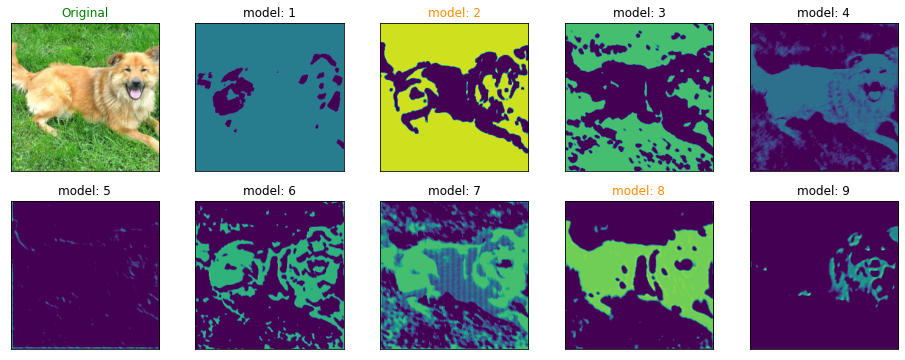

#####################################################################################################################


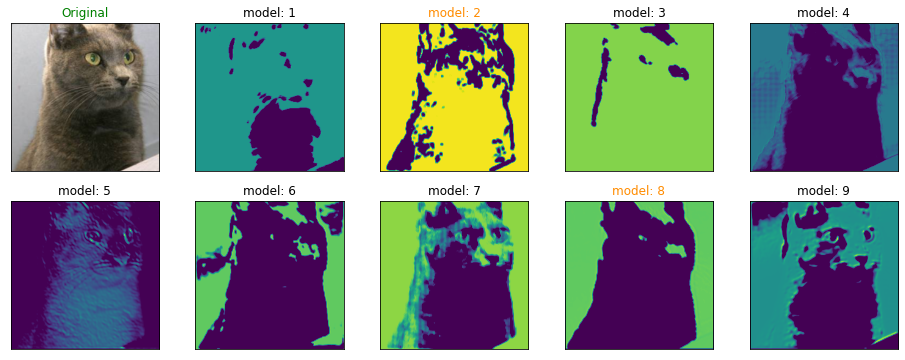

#####################################################################################################################


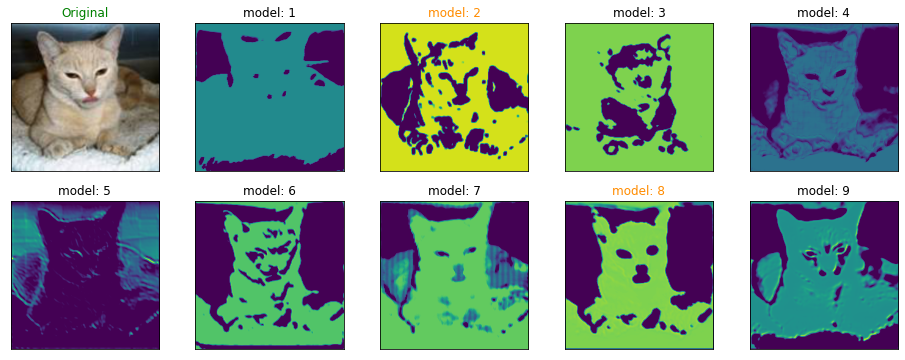

#####################################################################################################################


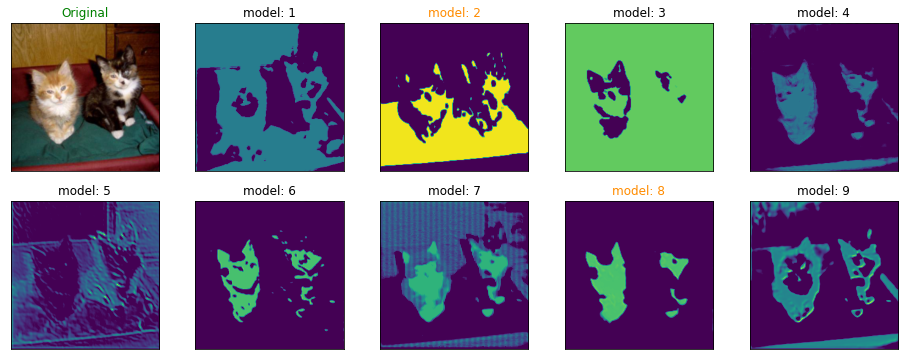

#####################################################################################################################


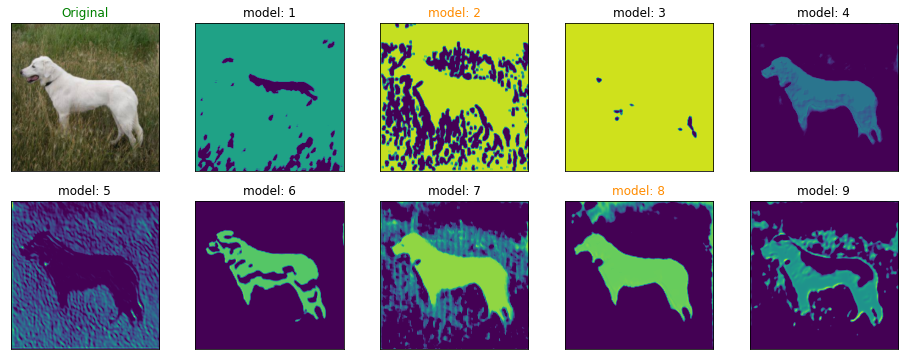

#####################################################################################################################


In [12]:
for img in images[:5]:
    show_results(weight_models_1, weight_models_2, img, device=device)

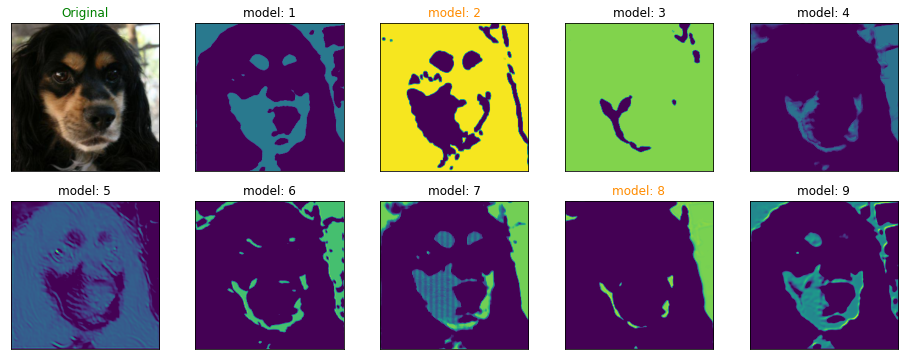

#####################################################################################################################


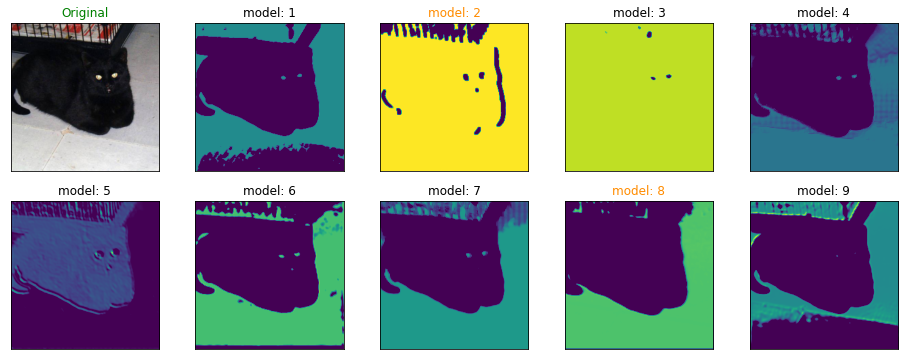

#####################################################################################################################


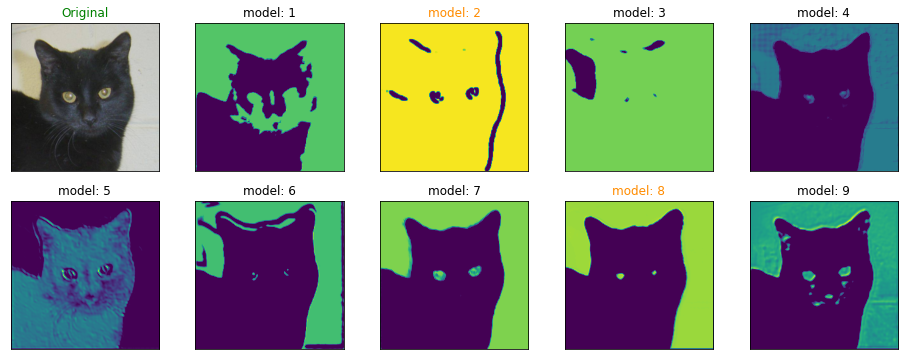

#####################################################################################################################


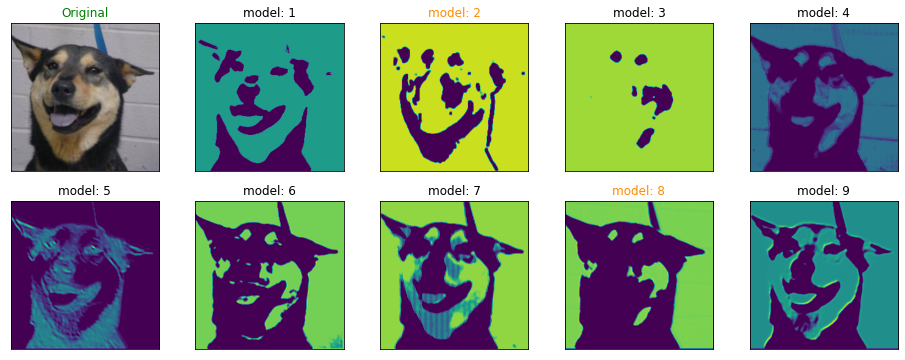

#####################################################################################################################


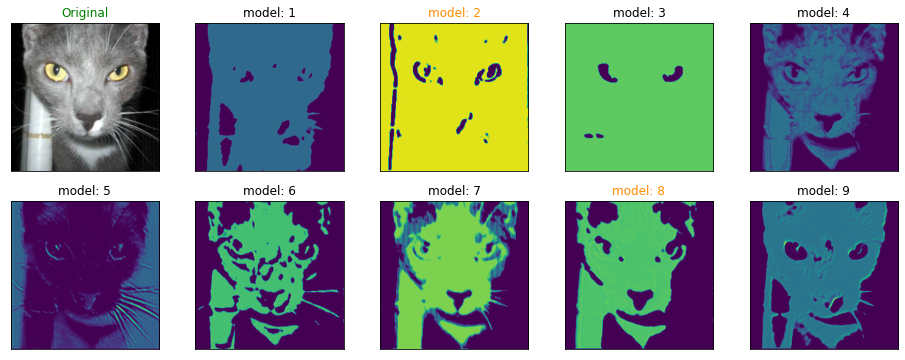

#####################################################################################################################


In [13]:
for img in images[5:]:
    show_results(weight_models_1, weight_models_2, img, device=device)